In [29]:
import pandas as pd

url_1 = 'https://raw.githubusercontent.com/nthu-datalab/ml/master/labs/08_CV_Ensembling/CV_playground_dataset/test.csv'
df1 = pd.read_csv(url_1)

url_2 = 'https://raw.githubusercontent.com/nthu-datalab/ml/master/labs/08_CV_Ensembling/CV_playground_dataset/train.csv'
df2 = pd.read_csv(url_2)

url_1 = 'https://raw.githubusercontent.com/nthu-datalab/ml/master/labs/08_CV_Ensembling/CV_playground_dataset/test.csv'
df3 = pd.read_csv(url_1)

df2["Competitor"].replace({"Kate": 0, "Bob": 1, "Mark":2, "Sue":3}, inplace=True)

df1 = pd.read_csv(url_1)
df1["Competitor"].replace({"Kate": 0, "Bob": 1, "Mark":2, "Sue":3}, inplace=True)


In [30]:
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
from sklearn.svm import SVC
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()


In [31]:
ohc = pd.get_dummies(df2)
y = np.array(ohc["Competitor"])
X = np.array(ohc.iloc[:, 0:2])

plot testing data: 


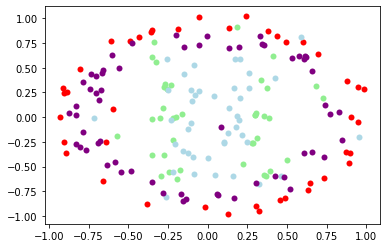

In [32]:

reader = df3.values.tolist()
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)


print('plot testing data: ')

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [33]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

clf_tree = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)




outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', AdaBoostClassifier(base_estimator=clf_tree)]])
    # hyperparameter tuning by grid search CV
    param_grid = {
                "clf__base_estimator__max_depth": [1, 5, 10, 15],
                "clf__n_estimators": [5, 10, 15, 20]

                }
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_estimators=%d RF max depth=%s selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_estimators'],gs.best_params_['clf__base_estimator__max_depth']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.70 (n_estimators=20 RF max depth=15 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.73 (n_estimators=10 RF max depth=10 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.70 (n_estimators=10 RF max depth=10 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.73 (n_estimators=20 RF max depth=10 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.54 (n_estimators=15 RF max depth=15 selected by inner 10-fold CV)

Test accuracy: 0.68 (5x10 nested CV)


In [ ]:
param_C = [0.1, 1.0, 10.0]


outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

clf1 = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1000, probability=True)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = AdaBoostClassifier(n_estimators=10, random_state=0)


outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', VotingClassifier(estimators=[('svm', clf1), ('rf', clf2), ('ada', clf3)], voting='soft')
]])

    param_grid = {'clf__svm__C': param_C,
                  'clf__rf__max_depth': [5, 10, 15],
                  'clf__ada__n_estimators': [5, 10, 15]

                  }
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (svm C=%d rf max_depth=%d n_estimators=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__svm__C'],gs.best_params_['clf__rf__max_depth'], gs.best_params_['clf__rf__max_depth']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.81 (svm C=0 rf max_depth=10 n_estimators=10 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.86 (svm C=0 rf max_depth=15 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.82 (svm C=10 rf max_depth=15 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (svm C=0 rf max_depth=15 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (svm C=0 rf max_depth=10 n_estimators=10 selected by inner 10-fold CV)

Test accuracy: 0.83 (5x10 nested CV)
0.8399851906701221
{'clf__ada__n_estimators': 15, 'clf__rf__max_depth': 10, 'clf__svm__C': 10.0}


In [ ]:
param_C = [0.1, 1.0, 10.0]


outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', BaggingClassifier(base_estimator=SVC(),n_estimators=10)]])

    param_grid = {'clf__base_estimator__C': param_C,
                  'clf__n_estimators': [5, 10, 15]

                  }
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (svm C=%d n_estimators=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__base_estimator__C'],gs.best_params_['clf__n_estimators']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.84 (svm C=10 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.83 (svm C=10 n_estimators=10 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.83 (svm C=10 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (svm C=10 n_estimators=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.84 (svm C=10 n_estimators=15 selected by inner 10-fold CV)

Test accuracy: 0.84 (5x10 nested CV)


# Result
Bagging classifier has the best accuaray with svc as the basic estimator with parameter svm C=10 and n_estimators=15.